In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

from scipy.optimize import least_squares as ls
from scipy.interpolate import CubicSpline
from scipy.optimize import minimize

In [2]:
spot = np.array(pd.read_csv("spot.csv").Spot)
S0 = spot[0]

IV_df = pd.read_csv("hist_spx.csv")
log_moneyness = np.log(np.array([80.0,90.0,95.0,97.5,100.0,102.5,105.0,110.0,120.0])/100)
maturities = np.array(IV_df['Exp Date']).flatten()
IV = np.array(IV_df.drop(columns = 'Exp Date'))/100.

nr = len(maturities)

In [3]:
start_time_all = time.time()
svi_param = np.zeros([nr,5])

for i in range(nr):

    def g(x,k):
        a,b,rho,m,sigma = x
        return a + b*(rho*(k-m)+np.sqrt((k-m)**2+sigma**2))
    
    def f(x):
        a,b,rho,m,sigma = x
        return np.sum(np.abs(g(x, log_moneyness) - IV[i,:]**2))

    def constraint(x):
        a,b,rho,m,sigma = x
        return a+b*sigma*np.sqrt(1-rho**2)

    param = np.zeros(5)
    con = {'type': 'ineq', 'fun': constraint, 'args': ()}
    bnds = ((-np.inf, np.inf), (0, np.inf), (-1, 1), (-np.inf, np.inf), (0, np.inf)) 
    solution = minimize(f, param, method='SLSQP', constraints = con, bounds = bnds)
    svi_param[i,:] = solution.x
    
total_time = (time.time() - start_time_all)
print(f'Total execution time: {total_time: .2f} s')

Total execution time:  0.46 s


In [4]:
market_svi = np.zeros(nr)
k = 0

def f(x):
    a,b,rho,m,sigma = x
    return np.sqrt(a + b*(rho*(k-m)+np.sqrt((k-m)**2+sigma**2)))

for i in range(nr):
    
    def g(x):
        a,b,rho,m,sigma = x
        return b * ((k-m)/np.sqrt((k-m)**2+sigma**2)+rho) / (2*f(x))
    
    market_svi[i] = np.abs(g(svi_param[i]))

Text(0.5, 1.0, 'Market skew SVI')

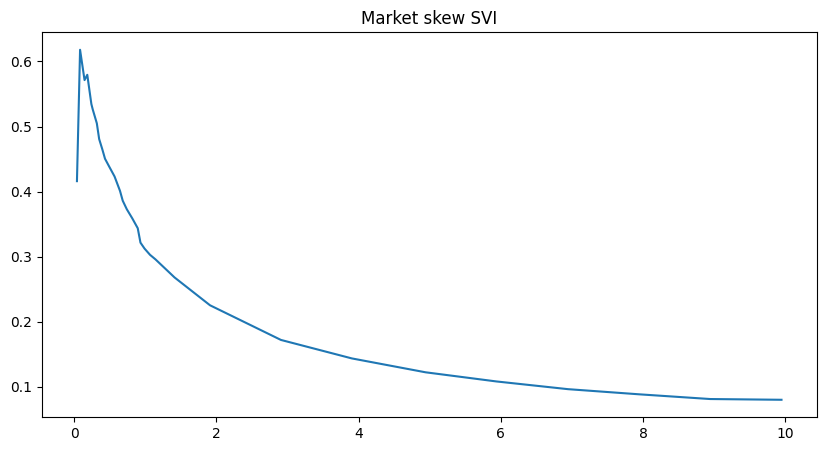

In [5]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)

plt.plot(maturities, market_svi)
plt.title("Market skew SVI")

In [6]:
for i in range(nr):
    
    def g(x, tau):
        A,alpha = x
        return A * tau**(-alpha)
    
    def f(x):
        return g(x, maturities) - market_svi
    
    result = ls(f, np.ones(2), max_nfev = 100, ftol = 1e-14, gtol = 1e-14, xtol = 1e-14)
    
    power_law_param = result.x

In [7]:
power_law_param

array([0.31193149, 0.25775459])

Text(0.5, 0, 'Tenor in years')

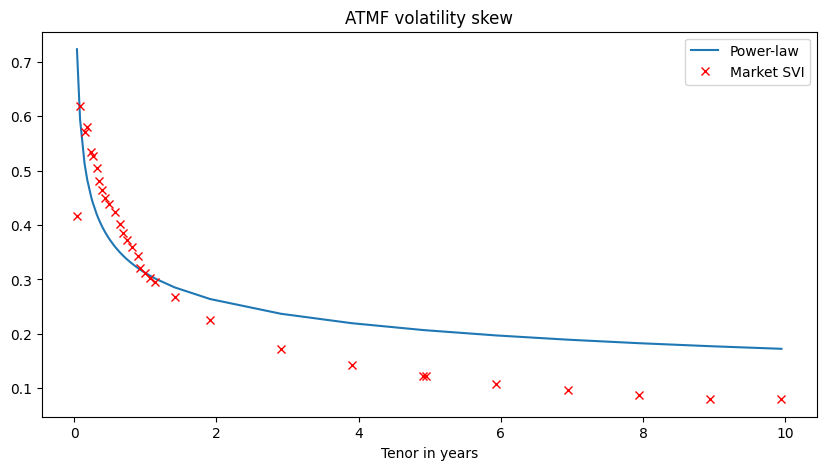

In [8]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)

def g(x):
    A,alpha = x
    return A * maturities**(-alpha)

plt.plot(maturities, g(power_law_param))
plt.plot(maturities, market_svi, 'rx')
plt.legend(["Power-law", "Market SVI"])
plt.title("ATMF volatility skew")
plt.xlabel("Tenor in years")

# Cubic Spline Approach

In [9]:
market_spline = np.zeros(nr)
h = 1e-3

for i in range(nr):
    cs = CubicSpline(log_moneyness, IV[i])
    market_spline[i] = (cs(-h)-cs(h))/(2*h)

Text(0.5, 1.0, 'Market skew spline')

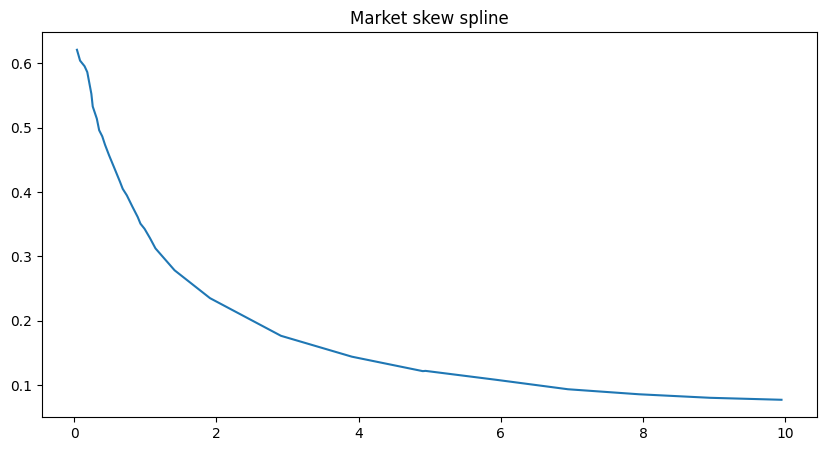

In [10]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)

plt.plot(maturities, market_spline)
plt.title("Market skew spline")

In [11]:
for i in range(nr):
    
    def g(x, tau):
        A,alpha = x
        return A * tau**(-alpha)
    
    def f(x):
        return g(x, maturities) - market_spline
    
    result = ls(f, np.ones(2), max_nfev = 100, ftol = 1e-14, gtol = 1e-14, xtol = 1e-14)
    
    power_law_param = result.x

In [12]:
power_law_param

array([0.32315518, 0.28440196])

Text(0.5, 0, 'Tenor in years')

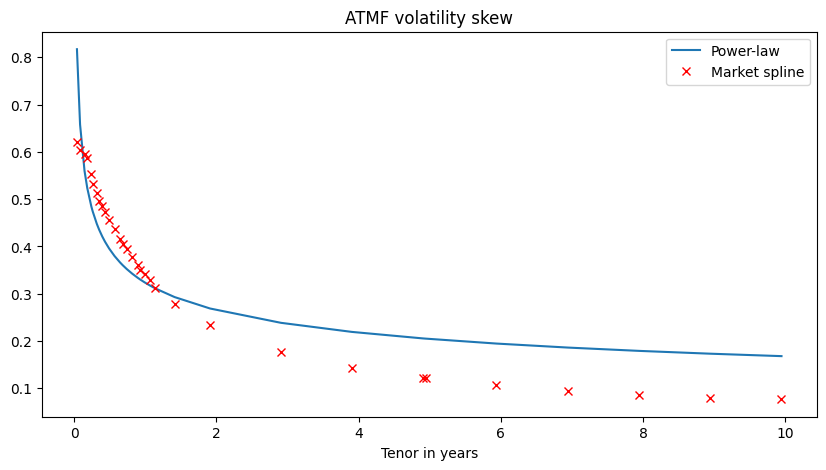

In [13]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)

def g(x):
    A,alpha = x
    return A * maturities**(-alpha)

plt.plot(maturities, g(power_law_param))
plt.plot(maturities, market_spline, 'rx')
plt.legend(["Power-law", "Market spline"])
plt.title("ATMF volatility skew")
plt.xlabel("Tenor in years")